## Imports

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from collections import Counter
from keras_visualizer import visualizer 
from keras.utils.vis_utils import plot_model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import json
import os
import import_data
import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Data import

In [51]:
COLUMNS = [\
    "LABEL","A_P_L1","A_V_L1","B_P_L1",
    "B_V_L1","A_P_L2","A_V_L2","B_P_L2",
    "B_V_L2","A_P_L3","A_V_L3","B_P_L3",
    "B_V_L3","A_P_L4","A_V_L4","B_P_L4",
    "B_V_L4","LC_1","LC_2","LC_3","LC_4",
    "LC_5",
    ]

In [52]:
def _norm_input_function(frame,path):
    if frame is None:
        if path is not None:
            frame = import_a_set(path)
        else:
            raise Exception("Error : Provide a dataframe to split")
    return frame
    
def import_a_set(path="data/Data_A.csv",is_test=False):
    frame = pd.read_csv(path,header=None)
    if is_test:
        frame.columns = [c for c in COLUMNS if c!="LABEL"]
    else:
        frame.columns = COLUMNS
    return frame

In [53]:
import_a_set().head()

,LABEL,A_P_L1,A_V_L1,B_P_L1,B_V_L1,A_P_L2,A_V_L2,B_P_L2,B_V_L2,A_P_L3,...,B_V_L3,A_P_L4,A_V_L4,B_P_L4,B_V_L4,LC_1,LC_2,LC_3,LC_4,LC_5
0,1,428900.0,1,428700.0,200,429000.0,100,428500.0,300,429100.0,...,300,429200.0,200,428300.0,100,0,1,0,1,0
1,1,427100.0,100,427000.0,100,427200.0,940,426900.0,100,427300.0,...,100,427400.0,700,426700.0,100,0,1,0,1,0
2,1,511300.0,100,511200.0,129,511400.0,500,511100.0,200,511500.0,...,300,511600.0,200,510900.0,300,0,1,1,0,0
3,0,415600.0,200,415400.0,100,415700.0,100,415300.0,100,415800.0,...,600,415900.0,300,415100.0,1020,0,1,1,0,1
4,0,506600.0,300,506500.0,100,506700.0,100,506300.0,200,506800.0,...,1099,506900.0,214,506100.0,699,0,0,1,1,0


## Feature engineering

### Util function

In [54]:
def mean_normalization(serie):
    return(serie-serie.mean())/serie.std()
def min_max_scaling(serie):
    return (serie - serie.min())/(serie.max()-serie.min())

def measure_random(sample):
    score =0
    for index in range(len(sample)-1):
        if sample[index]!=sample[index+1]:
            score+=1
    return score

def measure_entropy(sample):
    c = Counter(sample)
    e = 0
    for v in c.values():
        e-= v/len(sample) * np.log(v/len(sample))
    return e

In [210]:
def refactor_label(frame):
    frame["LABEL"] = frame["LABEL"] *2 -1
    frame["LABEL_UP"] = frame["LABEL"].apply(lambda x : 1 if x == 1 else 0)
    frame["LABEL_DOWN"] = frame["LABEL"].apply(lambda x : 1 if x == -1 else 0)
    frame =frame.drop("LABEL",axis=1)
    return frame

### Pipeline

In [55]:
def rescale_features_6(frame=None,path="data/Data_A.csv",no_label=False):
    """
    Frame : pd.DF or None => (Will fetch A set if None)
    path : str or None => Will fetch frame @ path if no frame is provided
    
    Rescales/adds feature/ applies non-linear tranformation to the features (No LABEL)
    """
    frame = _norm_input_function(frame,path)
    
    frame["MID_P"] = (frame["A_P_L1"] + frame["B_P_L1"]) / 2

    for side in ['A','B']:
        for level in range(1,5):
            mean = frame[f"{side}_P_L{level}"].mean()
            frame[f"{side}_P_L{level}_UM"] = frame[f"{side}_P_L{level}"].apply(lambda x : max(mean-x,0))
            frame[f"{side}_P_L{level}_OM"] = frame[f"{side}_P_L{level}"].apply(lambda x : max(x-mean,0))

    #GAP between levels of same side
    frame["A_D_1"] = (frame["A_P_L1"] - frame["MID_P"])
    frame["A_D_2"] = (frame["A_P_L2"] - frame["A_P_L1"])
    frame["A_D_3"] = (frame["A_P_L3"] - frame["A_P_L2"])
    frame["A_D_4"] = (frame["A_P_L4"] - frame["A_P_L3"])

    frame["B_D_1"] = (frame["B_P_L1"] - frame["MID_P"])
    frame["B_D_2"] = (frame["B_P_L2"] - frame["B_P_L1"])
    frame["B_D_3"] = (frame["B_P_L3"] - frame["B_P_L2"])
    frame["B_D_4"] = (frame["B_P_L4"] - frame["B_P_L3"])

    frame["LC_FP"] = (frame["LC_1"]  + frame["LC_2"]) - (frame["LC_3"]  + frame["LC_4"] + frame["LC_5"])
    frame["LC_FP_R"] = (frame["LC_1"]  + frame["LC_2"]) / (frame["LC_3"]  + frame["LC_4"] + frame["LC_5"]).apply(lambda x : max(1,x))

    frame["LC_CONCAT_RANDOM"] = (frame["LC_1"].apply(str) + frame["LC_2"].apply(str) +  frame["LC_3"].apply(str)  + frame["LC_4"].apply(str) + frame["LC_5"].apply(str)).apply(measure_random)
    frame["LC_CONCAT_ENTROPY"] = (frame["LC_1"].apply(str) + frame["LC_2"].apply(str) +  frame["LC_3"].apply(str)  + frame["LC_4"].apply(str) + frame["LC_5"].apply(str)).apply(measure_entropy)

    frame["SUM_V_A"] = frame["A_V_L1"] + frame["A_V_L2"] + frame["A_V_L3"] + frame["A_V_L4"]
    frame["SUM_V_B"] = frame["B_V_L1"] + frame["B_V_L2"] + frame["B_V_L3"] + frame["B_V_L4"]

    frame["V_M_L"] = frame["SUM_V_A"] - frame["SUM_V_B"]
    frame["V_M_L"] = frame["V_M_L"].apply(lambda x: 1 if x>0 else -1)

    frame["WPV_MID_DIF"] = -frame["MID_P"] * (frame["SUM_V_A"]+frame["SUM_V_B"])
    for side in ["A","B"]:
        for level in ["L1","L2","L3","L4"]:
            frame[f"WPV_{side}_{level}"] = frame[f"{side}_P_{level}"] * frame[f"{side}_V_{level}"]
            frame["WPV_MID_DIF"] += frame[f"WPV_{side}_{level}"]
            frame[f"{side}_V_{level}_PCT"] = frame[f"{side}_V_{level}"] / (frame["SUM_V_A"]+frame["SUM_V_B"]) 
            frame[f"WPV_{side}_{level}_PCT"] = frame[f"{side}_P_{level}"] * frame[f"{side}_V_{level}_PCT"]

    for side in ['A','B']:
        for level in range(1,5):
            frame[f"{side}_V_L{level}_LOG"] = np.log(frame[f"{side}_V_L{level}"])
    for col in frame.columns:
        if "LABEL" not in col and "LC" not in col and col!="V_M_L":
            frame[col] = (mean_normalization(frame[col]))
    for col in  ["LC_1","LC_2","LC_3","LC_4","LC_5"]:
        frame[col] = frame[col]*2 -1
    frame["LC_FP"] = mean_normalization(frame["LC_FP"])
    frame["LC_FP_R"] = mean_normalization(frame["LC_FP_R"])
    frame["LC_CONCAT_RANDOM"] = mean_normalization(frame["LC_CONCAT_RANDOM"])
    frame["LC_CONCAT_ENTROPY"] = mean_normalization(frame["LC_CONCAT_ENTROPY"])

    if not no_label:
        frame = refactor_label(frame)
    
    return frame

In [170]:
def rescale_features_0(frame=None,path="data/Data_A.csv",no_label=False): #No scaling, no feature added
    frame = _norm_input_function(frame,path)
    return frame

In [211]:
def rescale_features_1(frame=None,path="data/Data_A.csv",no_label=False): # stanardization scaling of the base feature
    frame = _norm_input_function(frame,path)

    for col in frame.columns:
        if "LC" not in col and "LABEL" not in col:
            frame[col] = mean_normalization(frame[col])
    if not no_label:
        frame = refactor_label(frame)
    return frame

In [56]:
rescale_features_6()

,A_P_L1,A_V_L1,B_P_L1,B_V_L1,A_P_L2,A_V_L2,B_P_L2,B_V_L2,A_P_L3,A_V_L3,...,A_V_L1_LOG,A_V_L2_LOG,A_V_L3_LOG,A_V_L4_LOG,B_V_L1_LOG,B_V_L2_LOG,B_V_L3_LOG,B_V_L4_LOG,LABEL_UP,LABEL_DOWN
0,-0.569214,-0.368506,-0.568954,-0.165387,-0.569458,-0.270024,-0.570871,-0.114624,-0.569719,-0.321398,...,-4.371940,-1.198542,-1.229947,-0.538995,0.028289,0.031872,-0.068090,-1.367316,1,0
1,-0.607898,-0.262434,-0.605511,-0.275880,-0.608134,0.426498,-0.605285,-0.291633,-0.608388,-0.146250,...,-0.518647,1.423132,-0.006554,0.845241,-0.562940,-1.277643,-1.340395,-1.367316,1,0
2,1.201639,-0.262434,1.205128,-0.243837,1.201050,0.061653,1.205715,-0.203129,1.200455,-0.233824,...,-0.518647,0.684531,-0.458072,-0.538995,-0.345740,-0.451431,-0.068090,-0.116743,1,0
3,-0.855043,-0.155292,-0.854958,-0.275880,-0.855232,-0.270024,-0.854781,-0.291633,-0.855439,-0.233824,...,0.061332,-1.198542,-0.458072,-0.090978,-0.562940,-1.277643,0.734645,1.276307,0,1
4,1.100632,-0.048149,1.104059,-0.275880,1.100062,-0.270024,1.102476,-0.203129,1.099486,-0.199670,...,0.400597,-1.198542,-0.259692,-0.464236,-0.562940,-0.451431,1.435558,0.846127,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.567065,0.058994,-0.566804,0.166092,-0.567309,-0.104185,-0.566570,0.239392,-0.567571,0.379196,...,0.641310,0.086855,1.216839,-0.090978,0.809851,1.041827,0.836217,0.210732,0,1
99996,-0.898025,-0.262434,-0.895815,0.166092,-0.898205,0.153694,-0.895647,0.024327,-0.898404,-0.058675,...,-0.518647,0.919107,0.313803,-0.090978,0.809851,0.533574,0.265075,0.999756,1,0
99997,-1.579288,0.060065,-1.577493,-0.275880,-1.579335,0.231638,-1.577460,0.327896,-1.579406,0.225065,...,0.643399,1.086538,0.974520,0.226895,-0.562940,1.200992,0.265075,0.210732,0,1
99998,-0.266192,-0.262434,-0.263597,-0.354330,-0.266495,-0.104185,-0.263302,-0.291633,-0.266813,-0.146250,...,-0.518647,0.086855,-0.006554,0.992786,-1.618802,-1.277643,0.265075,-0.578292,1,0


In [171]:
rescale_features_1()

,A_P_L1,A_V_L1,B_P_L1,B_V_L1,A_P_L2,A_V_L2,B_P_L2,B_V_L2,A_P_L3,A_V_L3,...,A_V_L4,B_P_L4,B_V_L4,LC_1,LC_2,LC_3,LC_4,LC_5,LABEL_UP,LABEL_DOWN
0,-0.569214,-0.368506,-0.568954,-0.165387,-0.569458,-0.270024,-0.570871,-0.114624,-0.569719,-0.321398,...,-0.238016,-0.570323,-0.427535,0,1,0,1,0,1,0
1,-0.607898,-0.262434,-0.605511,-0.275880,-0.608134,0.426498,-0.605285,-0.291633,-0.608388,-0.146250,...,0.145217,-0.604751,-0.427535,0,1,0,1,0,1,0
2,1.201639,-0.262434,1.205128,-0.243837,1.201050,0.061653,1.205715,-0.203129,1.200455,-0.233824,...,-0.238016,1.207012,-0.205106,0,1,1,0,0,1,0
3,-0.855043,-0.155292,-0.854958,-0.275880,-0.855232,-0.270024,-0.854781,-0.291633,-0.855439,-0.233824,...,-0.161369,-0.854353,0.595641,0,1,1,0,1,0,1
4,1.100632,-0.048149,1.104059,-0.275880,1.100062,-0.270024,1.102476,-0.203129,1.099486,-0.199670,...,-0.227285,1.103728,0.238641,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.567065,0.058994,-0.566804,0.166092,-0.567309,-0.104185,-0.566570,0.239392,-0.567571,0.379196,...,-0.161369,-0.566020,-0.093891,1,0,1,1,1,0,1
99996,-0.898025,-0.262434,-0.895815,0.166092,-0.898205,0.153694,-0.895647,0.024327,-0.898404,-0.058675,...,-0.161369,-0.895236,0.350968,0,1,0,1,0,1,0
99997,-1.579288,0.060065,-1.577493,-0.275880,-1.579335,0.231638,-1.577460,0.327896,-1.579406,0.225065,...,-0.084723,-1.577336,-0.093891,1,0,1,0,0,0,1
99998,-0.266192,-0.262434,-0.263597,-0.354330,-0.266495,-0.104185,-0.263302,-0.291633,-0.266813,-0.146250,...,0.221864,-0.262625,-0.316321,0,1,0,1,0,1,0


In [57]:
def split_training_data(frame = None,test_ratio = 0.1,path="Data/Data_A.csv"):
    
    frame = _norm_input_function(frame,path)
    test_frame = frame.sample(frac=test_ratio).reset_index(drop=True)
    train_frame = frame.drop(test_frame.index).reset_index(drop=True)

    return train_frame,test_frame  

In [58]:
def main_pipeline(path="data/Data_A.csv",feat_function:int=6,test_ratio:float = 0.1,split=True,split_before_scaling=True,no_label=False):
    frame = _norm_input_function(None,path)

    feature_engineering_fn  = globals()[f'rescale_features_{feat_function}']
    if split:
        if split_before_scaling:
            train_frame,test_frame = split_training_data(frame)

            train_frame = feature_engineering_fn(train_frame,no_label)
            test_frame = feature_engineering_fn(test_frame,no_label)

            return [train_frame,test_frame],train_frame.shape
        else:
            frame = feature_engineering_fn(frame,no_label)
            train_frame,test_frame = split_training_data(frame)
            return [train_frame,test_frame],train_frame.shape
    else:
        frame = feature_engineering_fn(frame,no_label)
        return [frame],frame.shape

### Data viz

#### Last tick change viz

In [70]:
def most_recent_tick():
    [df],_ = main_pipeline(feat_function=0,split=False)

    df = df.drop([c for c in df.columns if ("LC" not in c and c!="LABEL")],axis=1)
    df["CONCAT"] = df["LC_1"].apply(str) + df["LC_2"].apply(str) +  df["LC_3"].apply(str)  + df["LC_4"].apply(str) + df["LC_5"].apply(str)
    df = df.drop([c for c in df.columns if "LC" in c],axis = 1)
    bins = df["LABEL"].unique()
    df_0 = df[df["LABEL"]==0].drop("LABEL",axis=1).value_counts(sort=True)
    df_1 = df[df["LABEL"]==1].drop("LABEL",axis=1).value_counts(sort=True)

    df_count = pd.DataFrame(columns=["0","1"])
    df_count["0"] = df_0
    df_count["1"] = df_1
    df_count['ratio'] = (df_count["0"]/df_count["1"]).apply(lambda x : max(x,1/x))
    df_count = df_count.sort_values("ratio",ascending=False).drop("ratio",axis=1)

    df_count.index = [f"{k[0]}" for k in list(df_count.index)]

    fig = plt.figure(figsize=(25, 8))
    ax = fig.add_subplot(111)
    ax.plot([k for k in df_count.index],[round(measure_entropy(k),2) for k in df_count.index],color="red",linestyle="dashed",label="Entropy")
    ax.plot([k for k in df_count.index],[round(measure_random(k),2) for k in df_count.index],color="blue",linestyle="dashed",label="Random")

    bar_plot =df_count.plot(ax=ax,kind='bar', rot=0, xlabel='Serie', ylabel='Value', title='Distribution of Labels',secondary_y=True)
    # add some labels
    for c in ax.containers:
        # set the bar label
        ax.bar_label(c, fmt='%.0f', label_type='edge')
    ax.tick_params(axis='x', labelrotation=45)

    # move the legend out of the plot
    #ax.legend(handles= [bar_plot],title='Columns', bbox_to_anchor=(1, 1.02), loc='upper left')
    ax.legend()
    plt.show()

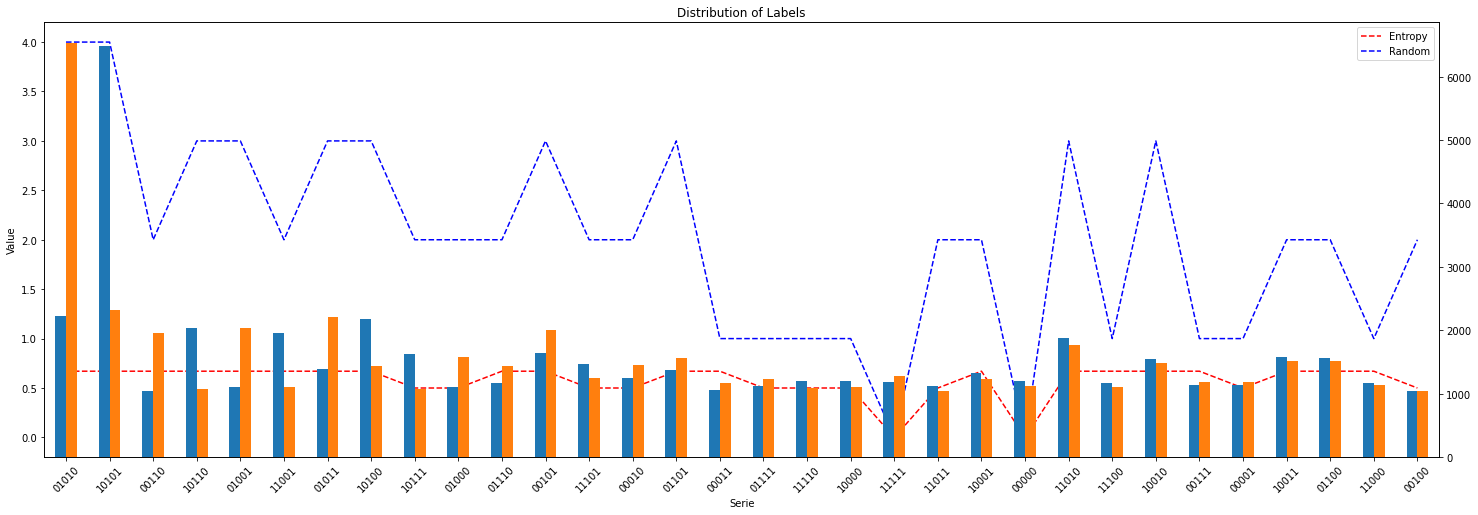

In [71]:
most_recent_tick()

#### Column distribution

In [83]:
def level_fig(frame,col,col_label,suffix="",bins=50,function = lambda x : x,title_suffix=""):
    side = ["A","B"]
    color=["blue","red"]
    side_label=["ASK","BID"]
    fig1, axs = plt.subplots(2,5,figsize=(40,10))
    fig2,ax2 = plt.subplots(1,1,figsize=(5,5))
    for i in range(2):
        for j in range(4):
            ax = axs[i,j]
            ax.set_title(f"{side_label[i]} {col_label} - Level : {j+1}")
            ax.set_xlabel(col_label)
            plt.xticks(rotation = 45)
            frame[f"{side[i]}_{col}_L{j+1}{suffix}"].apply(function).plot(kind="hist",bins=bins,color=color[i],ax=ax)
            frame[f"{side[i]}_{col}_L{j+1}{suffix}"].apply(function).plot(kind="hist",bins=bins,color=color[i],alpha=0.2,ax=axs[i,4])
            frame[f"{side[i]}_{col}_L{j+1}{suffix}"].apply(function).plot(kind="hist",bins=bins,color=color[i],alpha=0.2,ax=ax2)
    axs[0,4].set_title(f"ASK {col_label} - all levels")
    axs[1,4].set_title(f"BID {col_label} - all levels")
    ax2.set_title(f"All {title_suffix} {col_label} aggregated")
    return fig1,fig2

In [84]:
[frame],_ = main_pipeline(feat_function=6,split=False)

Volumes

(<Figure size 2880x720 with 10 Axes>, <Figure size 360x360 with 1 Axes>)

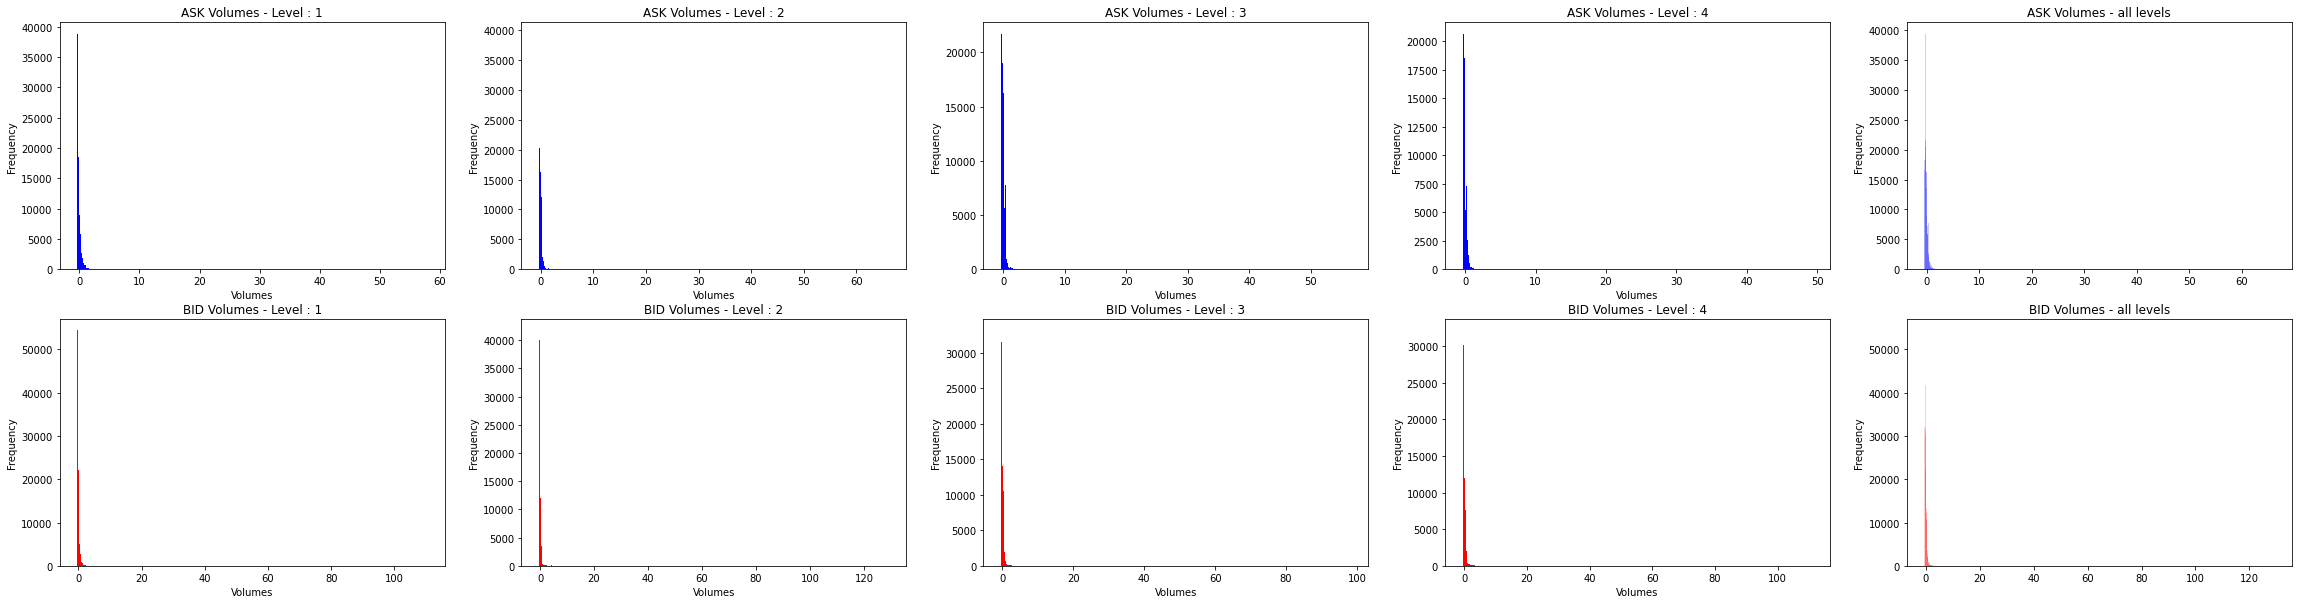

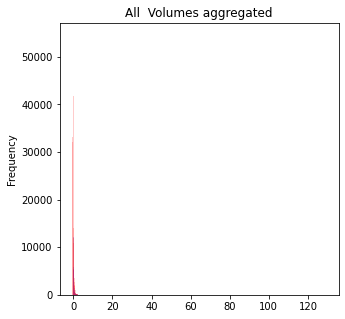

In [85]:
_,_  = level_fig(frame,"V","Volumes",bins=500) 

Log volumes

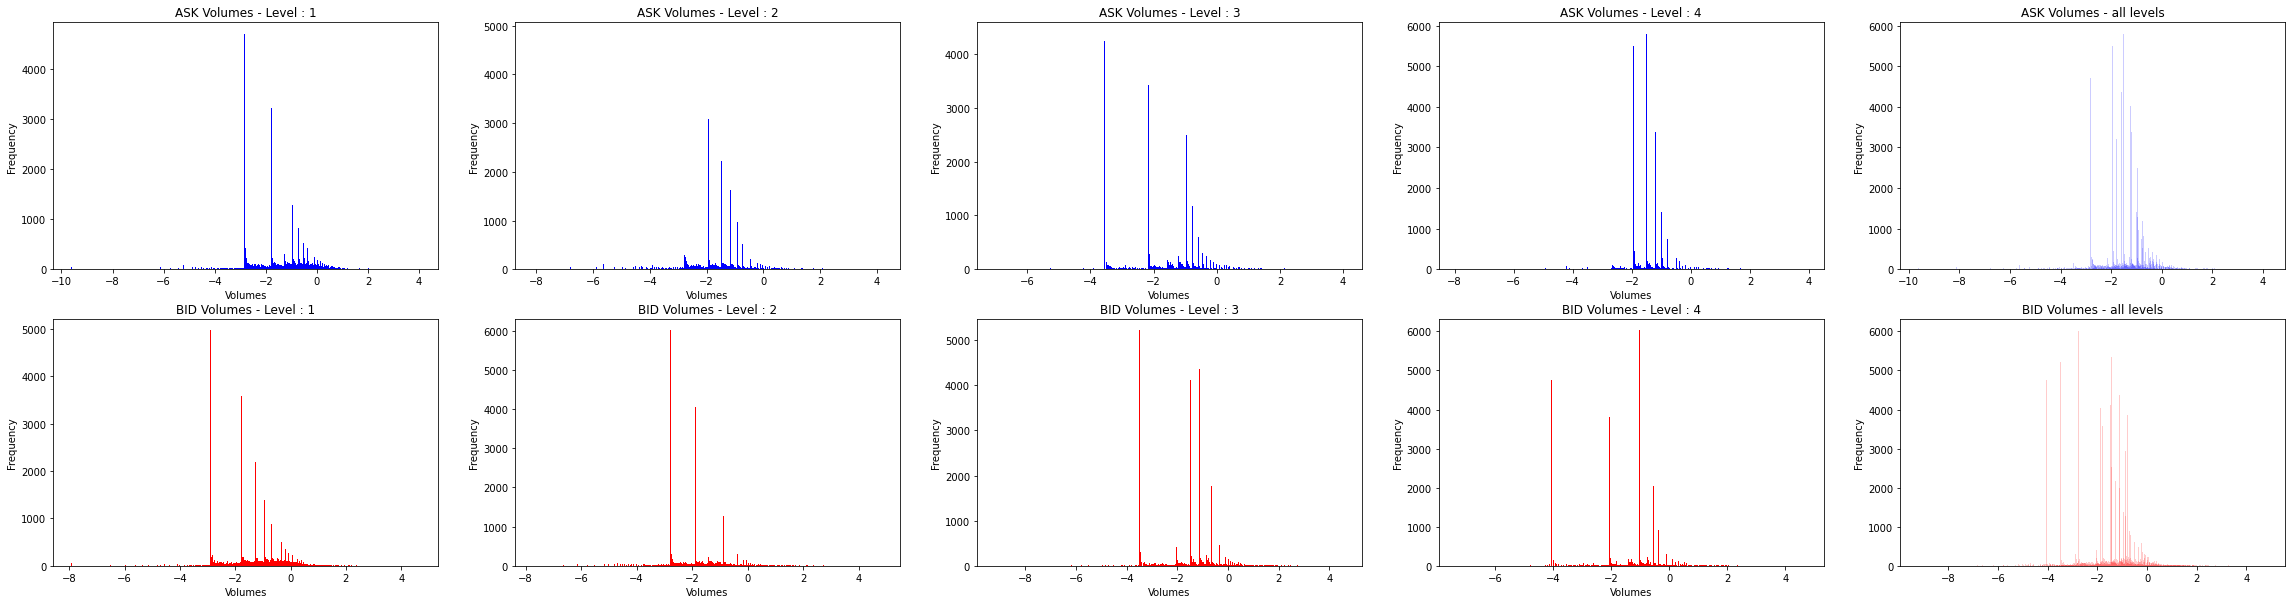

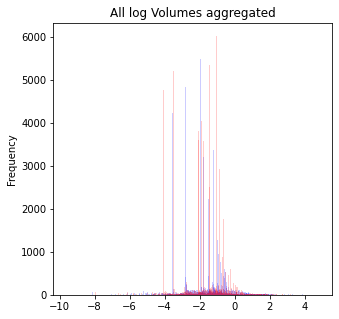

In [88]:
_,_ = level_fig(frame,"V","Volumes",bins=500,function=np.log,title_suffix="log")

Prices

(<Figure size 2880x720 with 10 Axes>, <Figure size 360x360 with 1 Axes>)

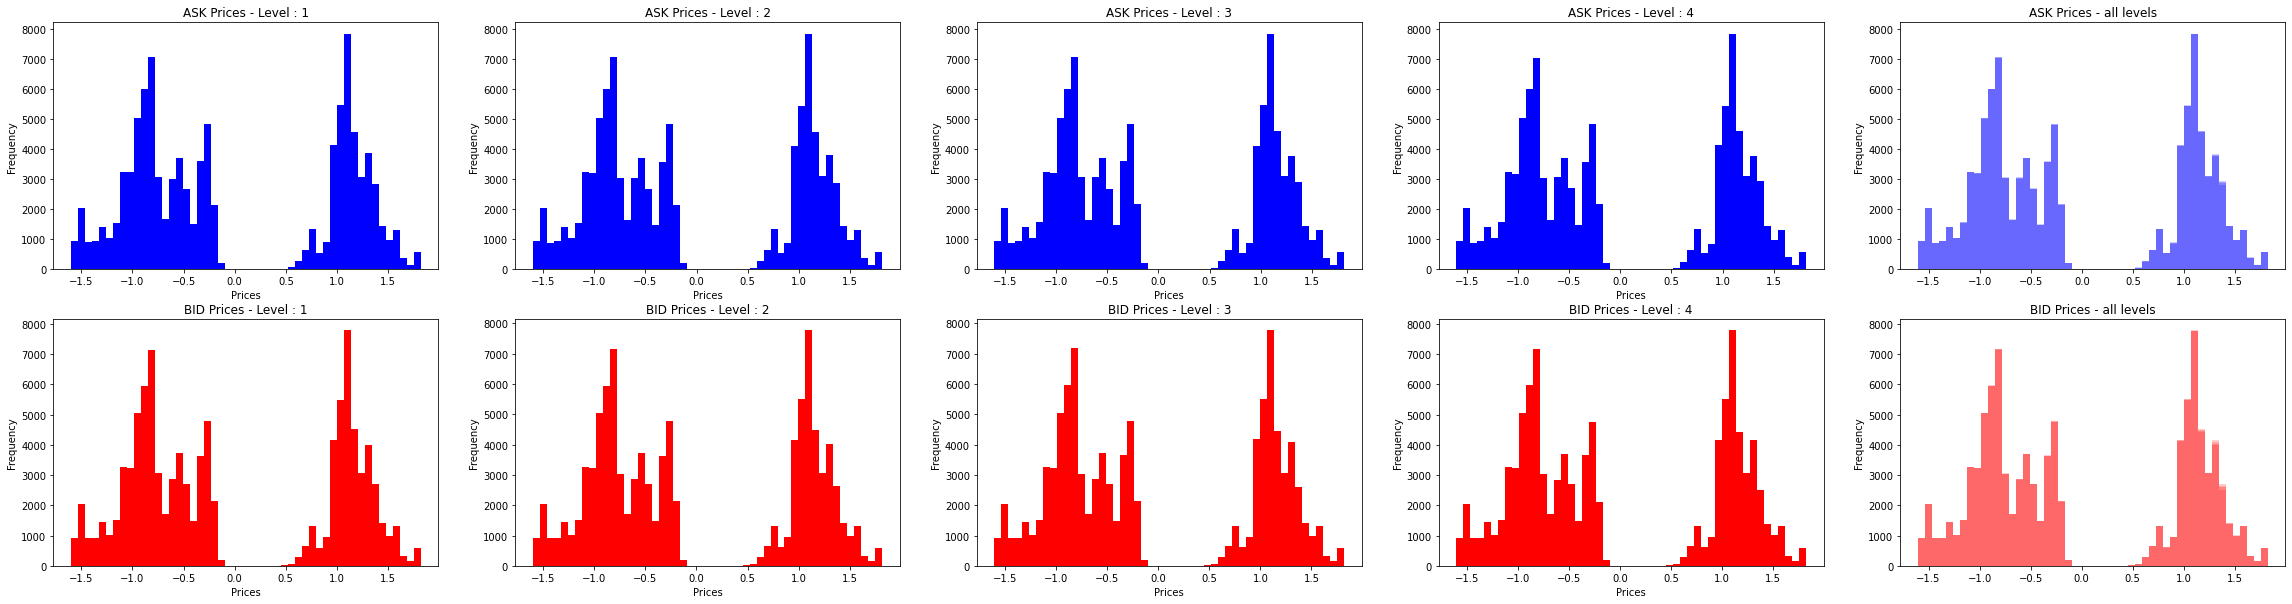

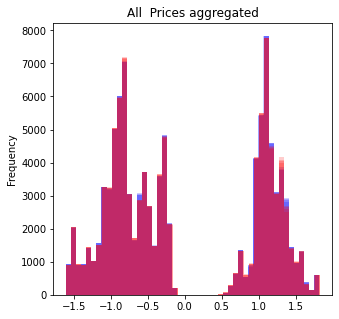

In [87]:
_,_ = level_fig(frame,"P","Prices",suffix="")

Prices Over/under mean

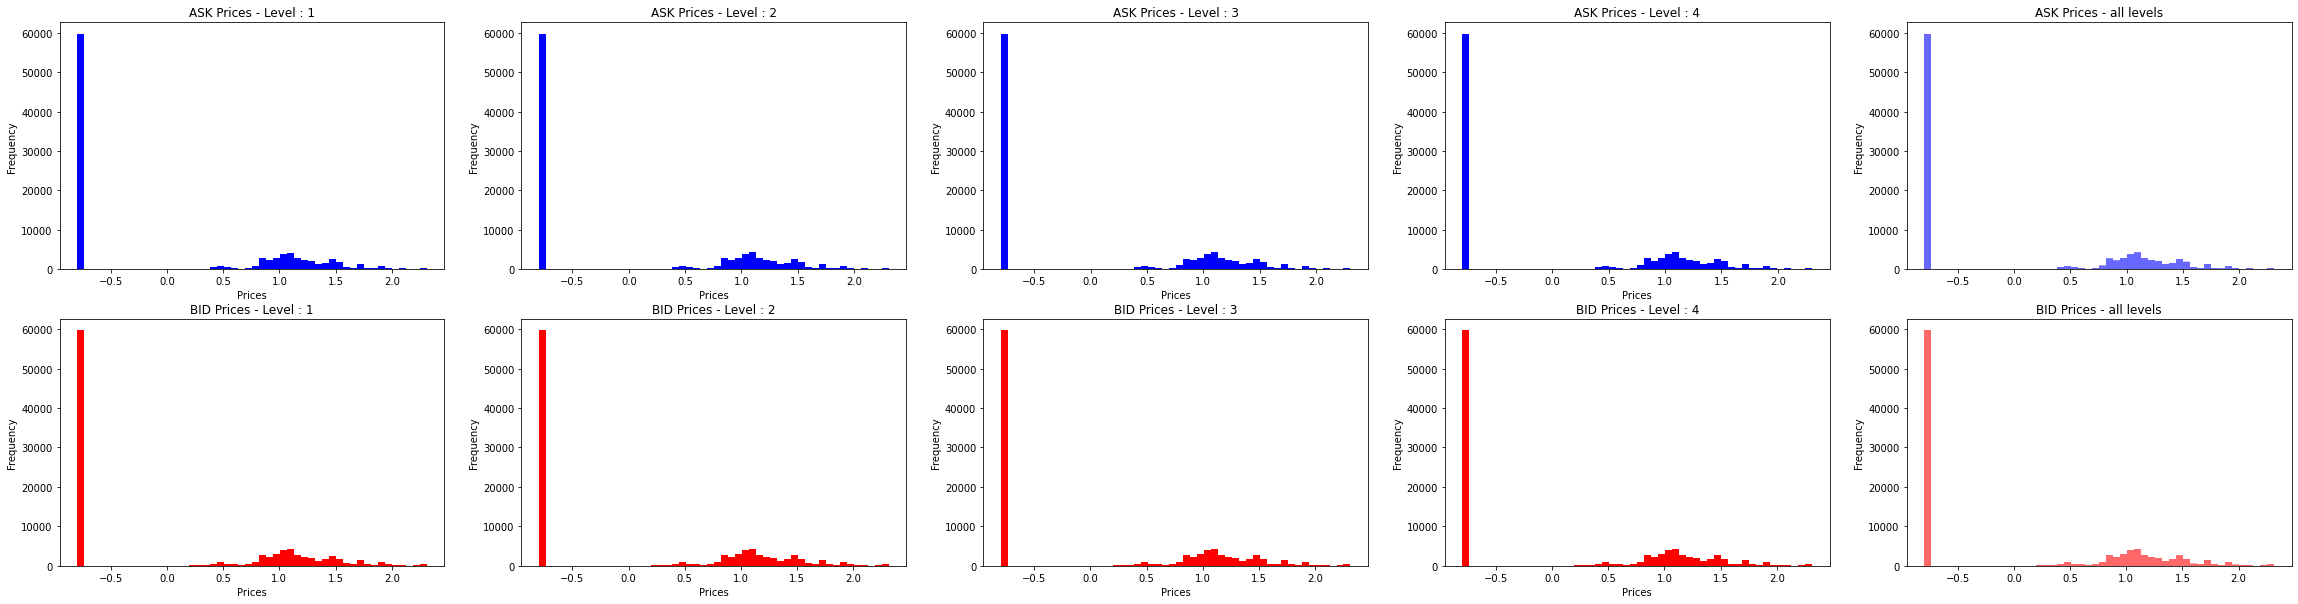

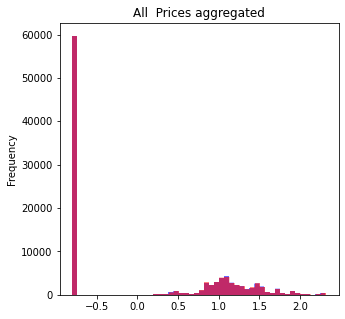

In [93]:
_,_ = level_fig(frame,"P","Prices",suffix="_OM")

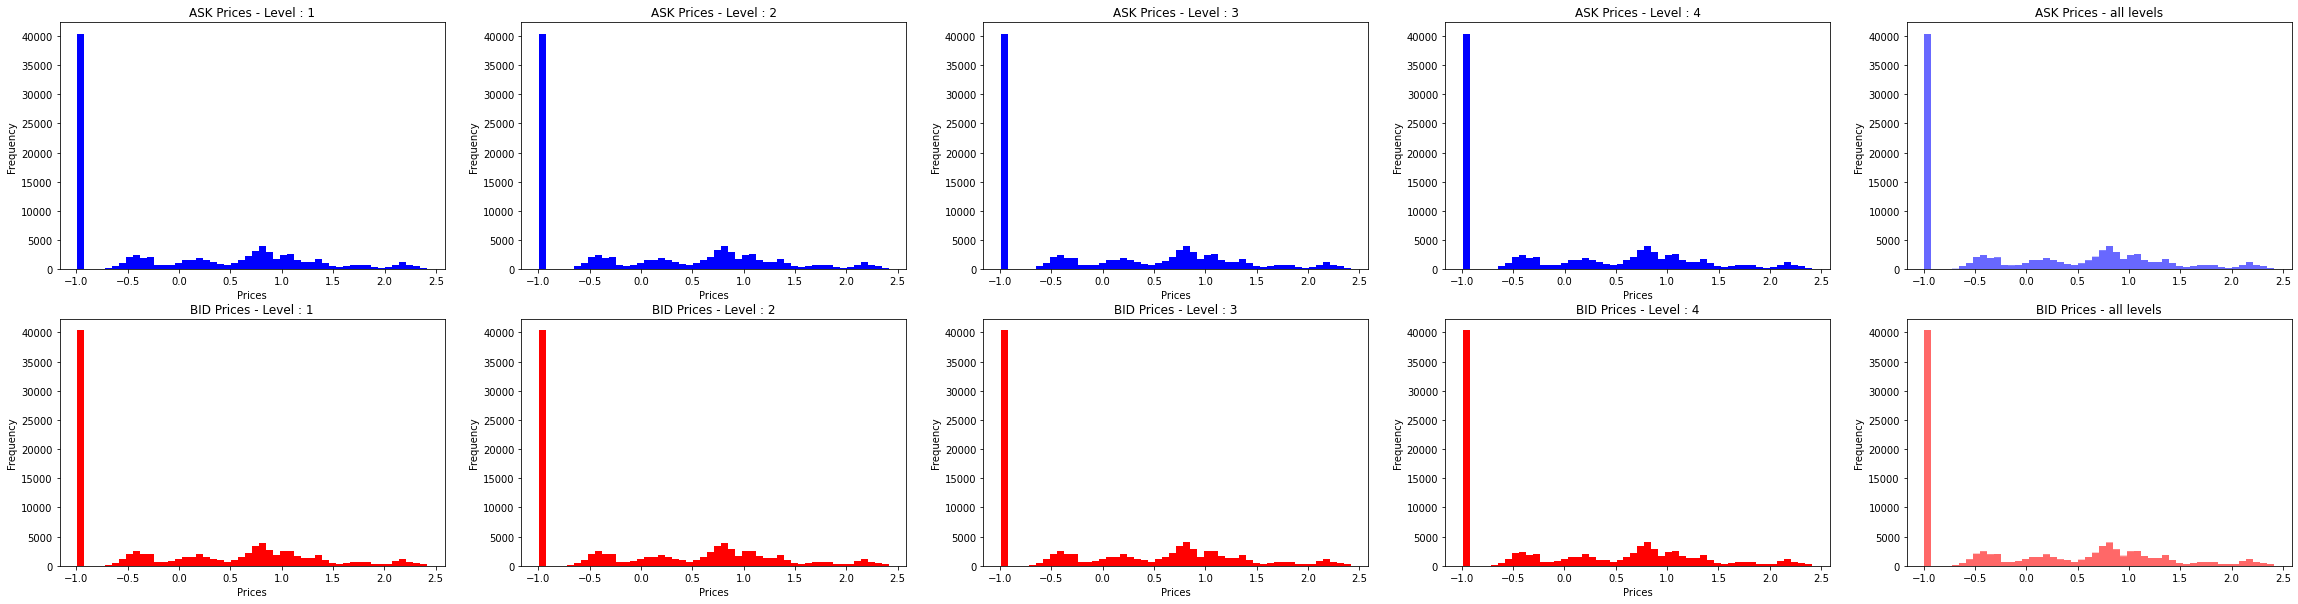

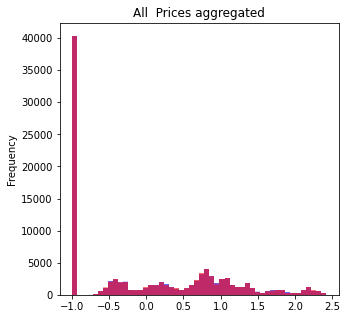

In [92]:
_,_ = level_fig(frame,"P","Prices",suffix="_UM")

#### Hyperparameter search

The json file are pre-generated (output of a gridsearch function which is very time-consumming)

In [162]:
def plot_3d_results(paths = ["cv_result_x_cloud.json","cv_result_x.json"],view_angle = 260,elev = 20):

    fig = plt.figure(figsize=(20,20))
    axs = []
    for i,path in enumerate(paths):
        df = pd.read_json(path)
        ax = fig.add_subplot(1, len(paths), i+1, projection='3d')
        axs.append(ax)
        colors = plt.cm.Spectral(df["mean_acc"].values/df["mean_acc"].values.max())
        batch_size = sorted(list(df["batch_size"].unique()))
        batch_dict = {b:2*i for i,b in enumerate(batch_size)}
        epochs = sorted(list(df["epochs"].unique()))
        epoch_dict = {e:2*i for i,e in enumerate(epochs)}
        x = []
        y= []
        z = []
        dx = []
        dy = []
        dz = []
        for _,row in df.iterrows():
            x.append(batch_dict.get(row["batch_size"]))
            y.append(epoch_dict.get(row["epochs"]))
            z.append(0)
            dx.append(1)
            dy.append(1)
            dz.append(row["mean_acc"])

        bb = ax.bar3d(x, y, z, dx, dy, dz, color=colors,cmap = plt.cm.Spectral)
        ax.set_xticks(list(batch_dict.values()))
        ax.set_yticks(list(epoch_dict.values()))
        ax.set_xticklabels(batch_size)
        ax.set_yticklabels(epochs)
        ax.set_title("Grid search of the optimal batch-size/epochs combination")
        ax.set_xlabel('Batch size')
        ax.set_ylabel('Epochs')
        ax.set_zlabel('Mean accuracy')
        ax.view_init(elev=elev, azim=view_angle)

    fig.colorbar(bb,label="Accuracy", orientation="horizontal",shrink=True, aspect=10,ax=axs)
    fig.show()


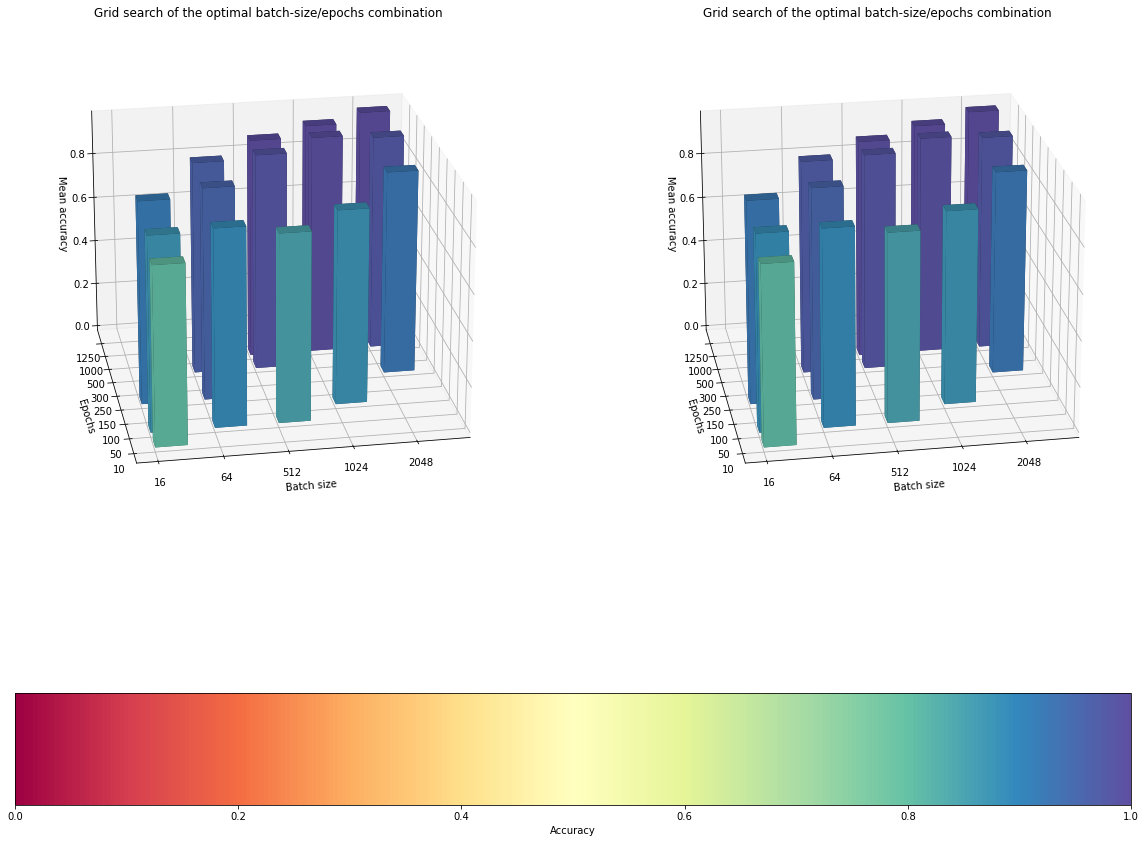

In [164]:
plot_3d_results(elev=22,view_angle=260)

## MODEL

### Util

In [59]:
def class_proba(row):
    if row[0]>row[1]:
        return 0
    else:
        return 1


def custom_accuracy(prediction : np.array,y_test):
    y_hat_values = np.apply_along_axis(class_proba, 1, prediction)
    y_test_values = np.apply_along_axis(class_proba,1,y_test.values)
    res = np.equal(y_hat_values,y_test_values)
    count = np.bincount(res)
    return count,len(res),count/len(res)

In [60]:
def create_model(plot=False,input_shape=86,hidden_neurons=100):
    
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_shape,)),
        keras.layers.Dense(hidden_neurons, activation="tanh",name="Hidden_layer_1"),
        keras.layers.Dense(hidden_neurons, activation="tanh",name="Hidden_layer_2"),
        keras.layers.Dense(hidden_neurons, activation="tanh",name="Hidden_layer_3"),
        keras.layers.Dense(2, activation="softmax",name="Output")
    ])
    model.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])
    if plot:
        plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model

### Testing the predictability

In [234]:
def plot_acc(history):
    h_values = history.history['accuracy']
    h_delta = [np.log(h_values[i+1]/h_values[i]) for i in range(len(h_values)-1)]
    fig,axs = plt.subplots(2,1,figsize=(15,8),sharex = True)
    ax1 = axs[0]
    ax1.plot(h_values)
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train accuracy'], loc='upper left')
    ax2 = axs[1]
    ax2.plot(h_delta,color="orange")
    ax2.plot([0 for _ in range(len(h_delta))], color = "b",linestyle="dashed")
    ax2.set_title('Accuracy Delta')
    ax2.set_ylabel('$\Delta_{Accuracy}$')
    ax2.legend(['train delta'], loc='upper left')
    ax2.set_xlabel('epoch')
    #fig.savefig(f"output/model_train_b{batch_size}_e{epoch}.png")
    return fig

In [63]:
def test_model_from_pipeline(model = None,feat_function=6,epoch = 600,batch_size = 1000,plot_accuracy = False,test_ratio = 0.1,prt=True,hidden_neurons=100,split_before_scaling = True):
    
    [train_frame,test_frame],input_shape = main_pipeline(feat_function=feat_function,test_ratio=test_ratio,split_before_scaling=split_before_scaling)
   
   
    y_train = train_frame[["LABEL_DOWN","LABEL_UP"]]
    x_train = train_frame.drop(["LABEL_DOWN","LABEL_UP"],axis=1)
    y_test = test_frame[["LABEL_DOWN","LABEL_UP"]]
    x_test = test_frame.drop(["LABEL_DOWN","LABEL_UP"],axis=1) 

    hidden_neurons = 30 if feat_function == 1 else hidden_neurons if hidden_neurons else 100
    model = model if model else create_model(input_shape=input_shape[1]-2,hidden_neurons = hidden_neurons)

    history = model.fit(x_train.to_numpy(), y_train.to_numpy(),epochs= epoch ,batch_size =batch_size,verbose=0)

    if plot_accuracy:
        fig = plot_acc(history)
        fig.show()
    
    _, accuracy = model.evaluate(x_test.to_numpy(), y_test.to_numpy())
    prediction = model.predict(x_test.to_numpy())
    _,_,(_,a) = custom_accuracy(prediction,y_test)

    if prt:
        print(f"Accuracy : {round(accuracy,4)*100}% || {a}")

    return accuracy  

#### Some runs to asses the quality of the model

Feature engineering + scaling the test and train together

313/313 [==============================] - 1s 1ms/step
Accuracy : 96.43% || 0.9643


0.9642999768257141

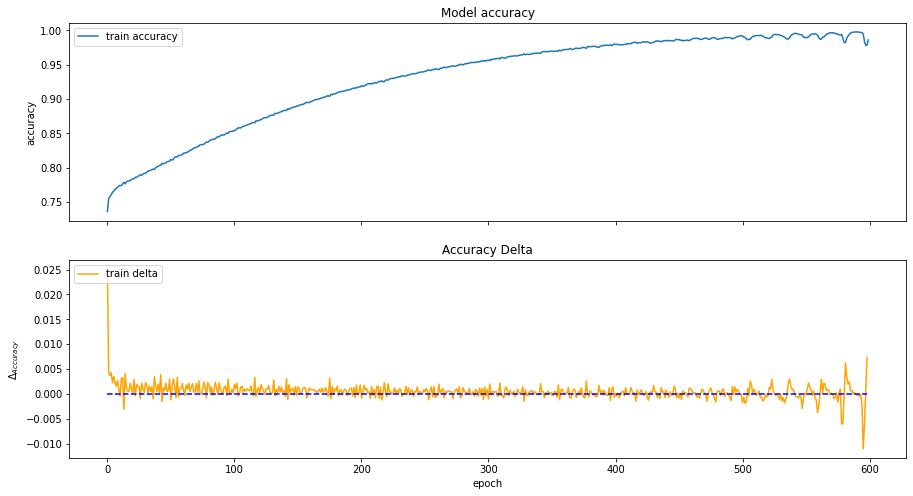

In [65]:
test_model_from_pipeline(feat_function=6,plot_accuracy=True,prt=True,split_before_scaling=False)

Feature engineering scaling the test and the train apart

313/313 [==============================] - 1s 3ms/step
Accuracy : 89.31% || 0.8931


0.8931000232696533

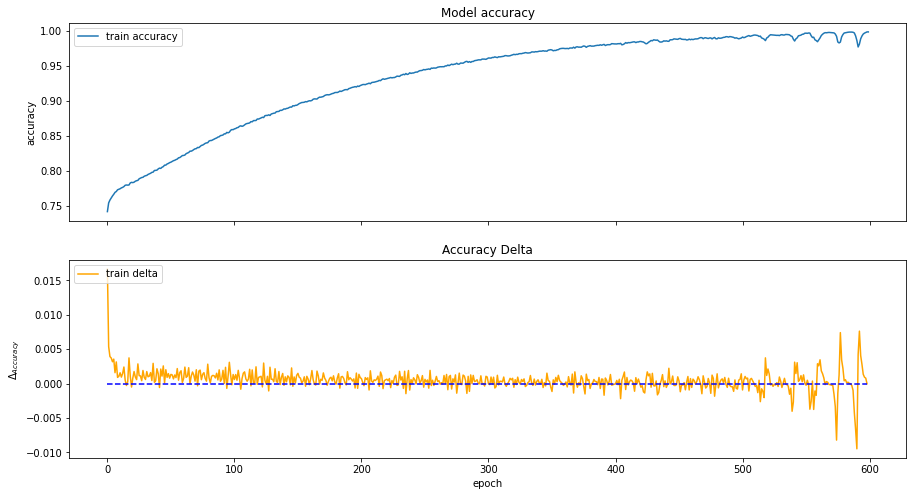

In [66]:
test_model_from_pipeline(feat_function=6,plot_accuracy=True,prt=True,split_before_scaling=True)

Standardization of the base feature + scaling the test and train together

313/313 [==============================] - 0s 1ms/step
Accuracy : 78.57% || 0.7857


0.7857000231742859

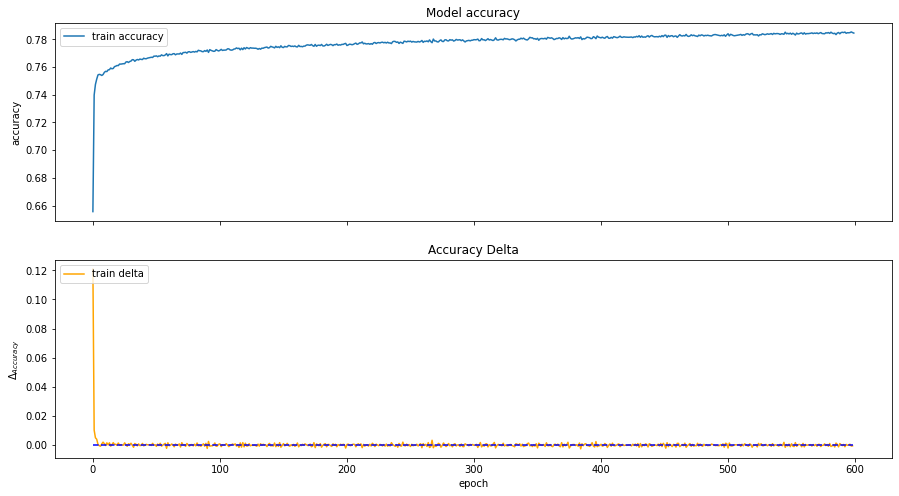

In [174]:
test_model_from_pipeline(feat_function=1,plot_accuracy=True,prt=True,split_before_scaling=False)

Standardization of the base feature + scaling the test and train apart

313/313 [==============================] - 0s 1ms/step
Accuracy : 72.65% || 0.7265


0.7264999747276306

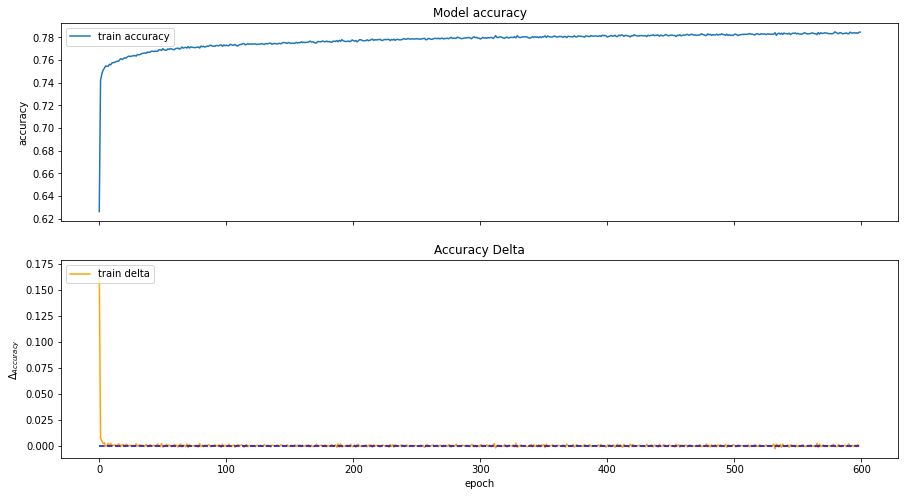

In [173]:
test_model_from_pipeline(feat_function=1,plot_accuracy=True,prt=True,split_before_scaling=True)

## Prediction of the labels

Importing both dataset together and concatening them

In [224]:
frame_train = import_a_set(path="data/Data_A.csv",is_test=False)
feat_test = import_a_set(path="data/Data_B_nolabels.csv",is_test=True)

frame_train.index = [f"train_{i}" for i in frame_train.index]
feat_test.index = [f"test{i}" for i in feat_test.index]

In [225]:
no_label_train = frame_train.drop("LABEL",axis=1)
scaled_feat = rescale_features_6(frame=pd.concat([no_label_train,feat_test]),no_label=True)

x_train = scaled_feat[scaled_feat.index.isin(frame_train.index)]
y_train = refactor_label(frame_train)[["LABEL_DOWN","LABEL_UP"]]
x_test = scaled_feat[scaled_feat.index.isin(feat_test.index)]

Creating and fitting the model

In [226]:
model = create_model(input_shape=x_train.shape[1])
history = model.fit(x_train.to_numpy(),y_train.to_numpy(),batch_size=1000,epochs=300,verbose=0)

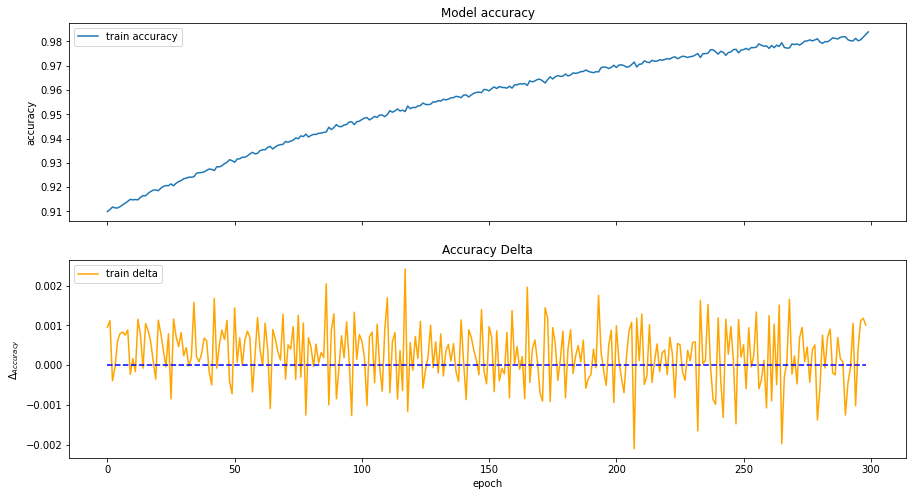

In [235]:
_=plot_acc(history=history)

In [237]:
prediction_array = model.predict(x_test.to_numpy())
y_test = pd.DataFrame(columns=["LABEL"])
y_test["LABEL"] = np.apply_along_axis(class_proba,1,prediction_array)
y_test

313/313 [==============================] - 1s 3ms/step


In [240]:
np.savetxt("data/02289032_DEDIEU.txt", y_test.values, fmt='%d')

In [238]:
y_test.to_csv("data/02289032_DEDIEU.csv",index=False,header=False)

,LABEL
0,0
1,0
2,0
3,1
4,0
...,...
9995,1
9996,0
9997,0
9998,1
